In [26]:
!pip install -q kaggle

In [27]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"kavanabm","key":"32d6c6e18ddaf2ec3e094108b64c435c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d osamajalilhassan/bone-fracture-dataset


Dataset URL: https://www.kaggle.com/datasets/osamajalilhassan/bone-fracture-dataset
License(s): unknown
 74% 127M/173M [00:00<00:00, 1.32GB/s]
100% 173M/173M [00:00<00:00, 1.07GB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bone-fracture-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
import seaborn as sns
import cv2
import pandas as pd
import time

In [7]:
DATADIR ='/content/BoneFractureDataset'
CATEGORIES = ['fractured','not_fractured']

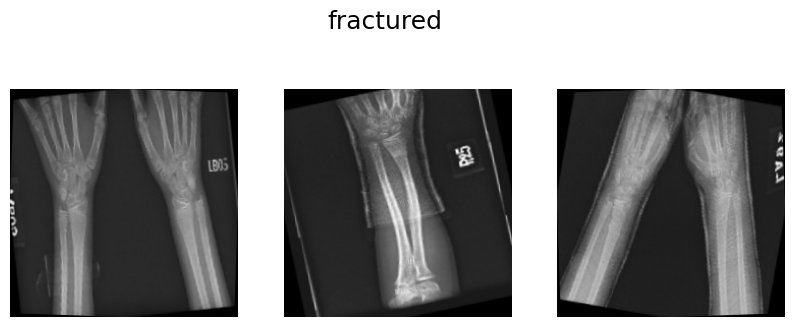

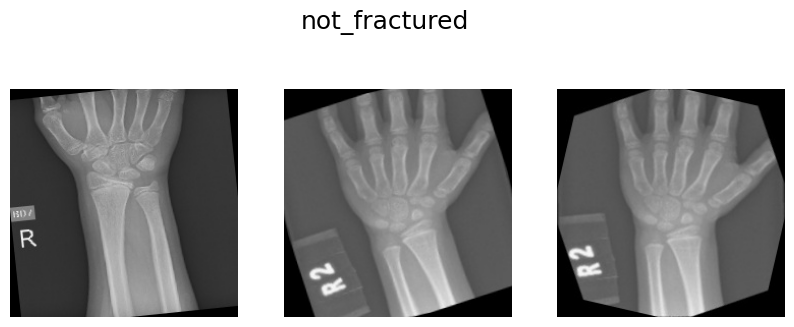

In [8]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, 'testing', category)  # or 'training' if you want to visualize training images
    images = os.listdir(path)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        ax[i].imshow(img_rgb)
        ax[i].axis('off')

    plt.show()

In [9]:
import os
import cv2

# Set the dataset directory and categories
DATADIR = '/content/BoneFractureDataset/training'  # Use training directory
CATEGORIES = ['fractured', 'not_fractured']
IMG_SIZE = 224 # Set your desired image size (e.g., 100x100)

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Include the category folder (fractured/not_fractured)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
                training_data.append([new_array, class_num])  # Append resized image and class number
            except Exception as e:
                pass  # In case of errors, just skip the image

create_training_data()
print(f"✅ Training samples: {len(training_data)}")


✅ Training samples: 8863


In [10]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)



In [11]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'✅ X_train shape: {X_train.shape}')
print(f'✅ X_val shape:   {X_val.shape}')



✅ X_train shape: (7090, 224, 224, 3)
✅ X_val shape:   (1773, 224, 224, 3)


In [12]:
# Define test data directory
TESTDIR = '/content/BoneFractureDataset/testing'

# Initialize test data list
test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(TESTDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_array, class_num])
            except Exception as e:
                pass

# Create the test data
create_test_data()

# Split features and labels
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

# Convert to numpy arrays
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Show shape
print(f'✅ X_test shape: {X_test.shape}')
print(f'✅ y_test shape: {y_test.shape}')


✅ X_test shape: (600, 224, 224, 3)
✅ y_test shape: (600,)


In [13]:
IMG_SIZE = 224  # instead of 100


In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# The line below is not needed as new_array is not used in the model definition
# new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

# Define the input shape for the model
input_shape = (IMG_SIZE, IMG_SIZE, 3)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

<ipython-input-15-411811c2bce7>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

✅ Training samples collected: 8863
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.6118 - loss: 0.6535 - val_accuracy: 0.7107 - val_loss: 0.5621
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7500 - loss: 0.5227 - val_accuracy: 0.7676 - val_loss: 0.5042
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7876 - loss: 0.4741 - val_accuracy: 0.7783 - val_loss: 0.4664
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8295 - loss: 0.4148 - val_accuracy: 0.8020 - val_loss: 0.4320
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8526 - loss: 0.3803 - val_accuracy: 0.8291 - val_loss: 0.3937
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8759 - loss: 0.3448 - val_accuracy: 0.8387 - val_loss: 0.3719
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8877 - loss: 0.3176 - val_accuracy: 0.8477 - val_loss: 0.3574
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - acc

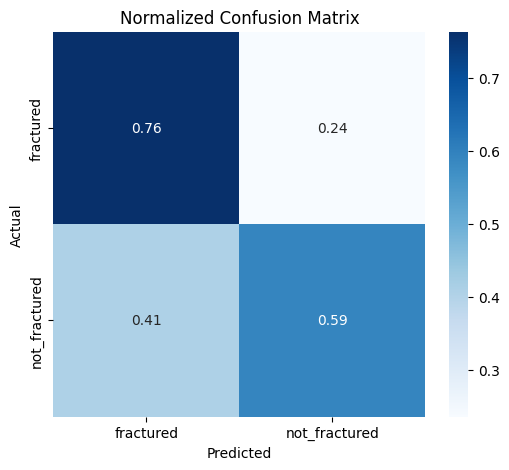


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600    MobileNetV2 (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy      10         0.0001            105483.21               0.92               0.8759             0.695 0.2418           0.3041     0.6926   0.695    

In [29]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: MobileNetV2 Model ==========
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in mobilenet.layers:
    layer.trainable = False

model = keras.Sequential([
    mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "MobileNetV2",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.0001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.6026 - loss: 0.7796 - val_accuracy: 0.7056 - val_loss: 0.5861
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7604 - loss: 0.4921 - val_accuracy: 0.7721 - val_loss: 0.4578
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8242 - loss: 0.3892 - val_accuracy: 0.8353 - val_loss: 0.3731
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8727 - loss: 0.3126 - val_accuracy: 0.8697 - val_loss: 0.3120
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8943 - loss: 0.2575 - val_accuracy: 0.8900 - val_loss: 0.2702
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9223 - loss: 0.2095 - val_accuracy: 0.8810 - val_loss: 0.2748
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9346 - loss: 0.1720 - val_accuracy: 0.8940 - val_loss: 0.2595
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - ac

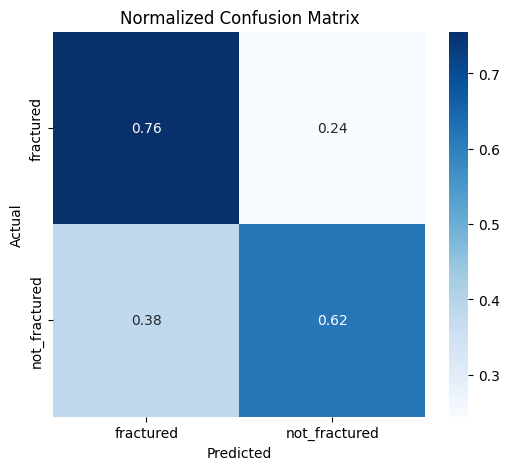


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600    MobileNetV2 (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy      10          0.001            101161.02             0.9621               0.9267               0.7 0.1075           0.1875     0.6992     0.7    

In [33]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: MobileNetV2 Model ==========
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in mobilenet.layers:
    layer.trainable = False

model = keras.Sequential([
    mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "MobileNetV2",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.6068 - loss: 0.7550 - val_accuracy: 0.7586 - val_loss: 0.4983
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7637 - loss: 0.4858 - val_accuracy: 0.8201 - val_loss: 0.4099
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8441 - loss: 0.3688 - val_accuracy: 0.8556 - val_loss: 0.3451
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8789 - loss: 0.2838 - val_accuracy: 0.8748 - val_loss: 0.3255
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9193 - loss: 0.2157 - val_accuracy: 0.8409 - val_loss: 0.3628
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9254 - loss: 0.1902 - val_accuracy: 0.8911 - val_loss: 0.2561
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9371 - loss: 0.1605 - val_accuracy: 0.9171 - val_loss: 0.2213
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - ac

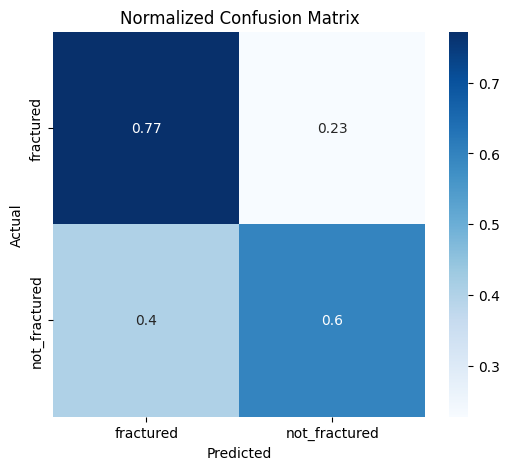


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600    MobileNetV2 (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy      15          0.001            155012.63             0.9879               0.9374            0.7017 0.0404           0.1541      0.699  0.7017    

In [31]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: MobileNetV2 Model ==========
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in mobilenet.layers:
    layer.trainable = False

model = keras.Sequential([
    mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "MobileNetV2",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 15,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.5601 - loss: 2.1305 - val_accuracy: 0.7039 - val_loss: 0.5662
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7330 - loss: 0.5402 - val_accuracy: 0.7242 - val_loss: 0.5319
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7929 - loss: 0.4447 - val_accuracy: 0.7941 - val_loss: 0.4401
Epoch 4/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8266 - loss: 0.3798 - val_accuracy: 0.8009 - val_loss: 0.4207
Epoch 5/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8274 - loss: 0.3837 - val_accuracy: 0.8206 - val_loss: 0.3960
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.7083 - loss: 0.5495
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step

📌 Classification Report:

               precision    recall  f1-score   support

    fractured       0.78      0.74      0.76       360
not_fractured       0.64      0.69      0.66       240

     accurac

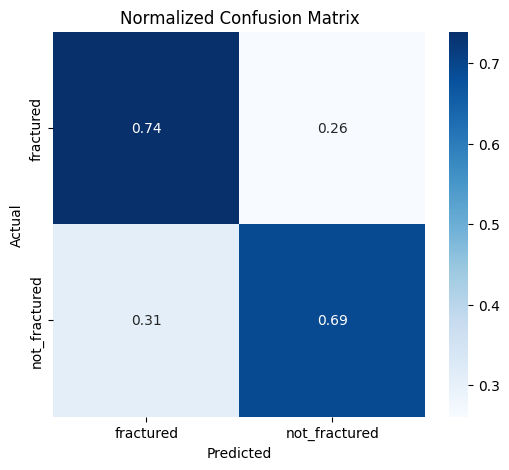


📊 Final MobileNetV2 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       2         9463           7090           600    MobileNetV2 (224, 224, 3)                  4                      512                relu                       1             sigmoid      Adam binary_crossentropy       5           0.01             61226.54             0.8317               0.8206              0.72 0.3713            0.396     0.7248    0.72    

In [28]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: MobileNetV2 Model ==========
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in mobilenet.layers:
    layer.trainable = False

model = keras.Sequential([
    mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []
for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 2,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "MobileNetV2",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 4,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 5,
    "Learning Rate": 0.01,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final MobileNetV2 Summary:\n")
print(df_result.to_string(index=False))


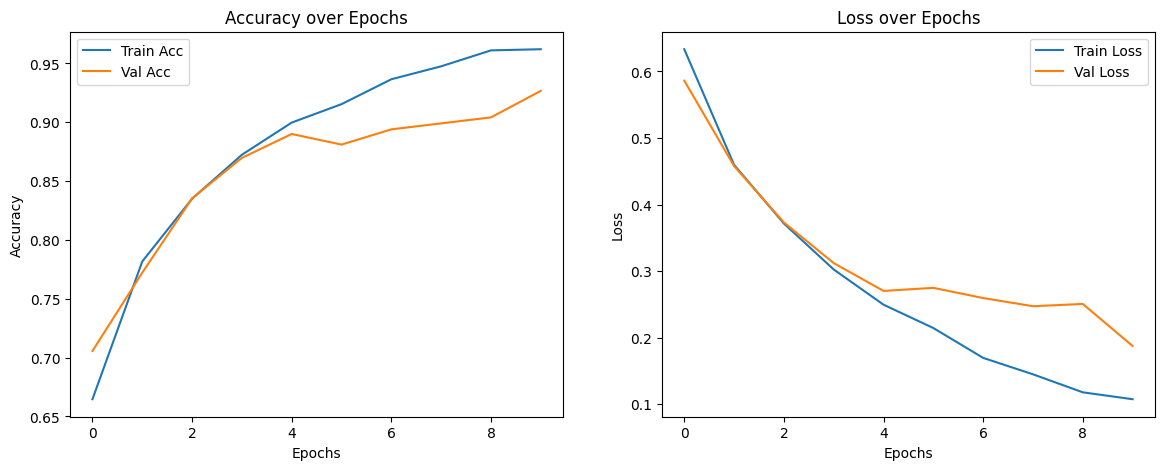

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


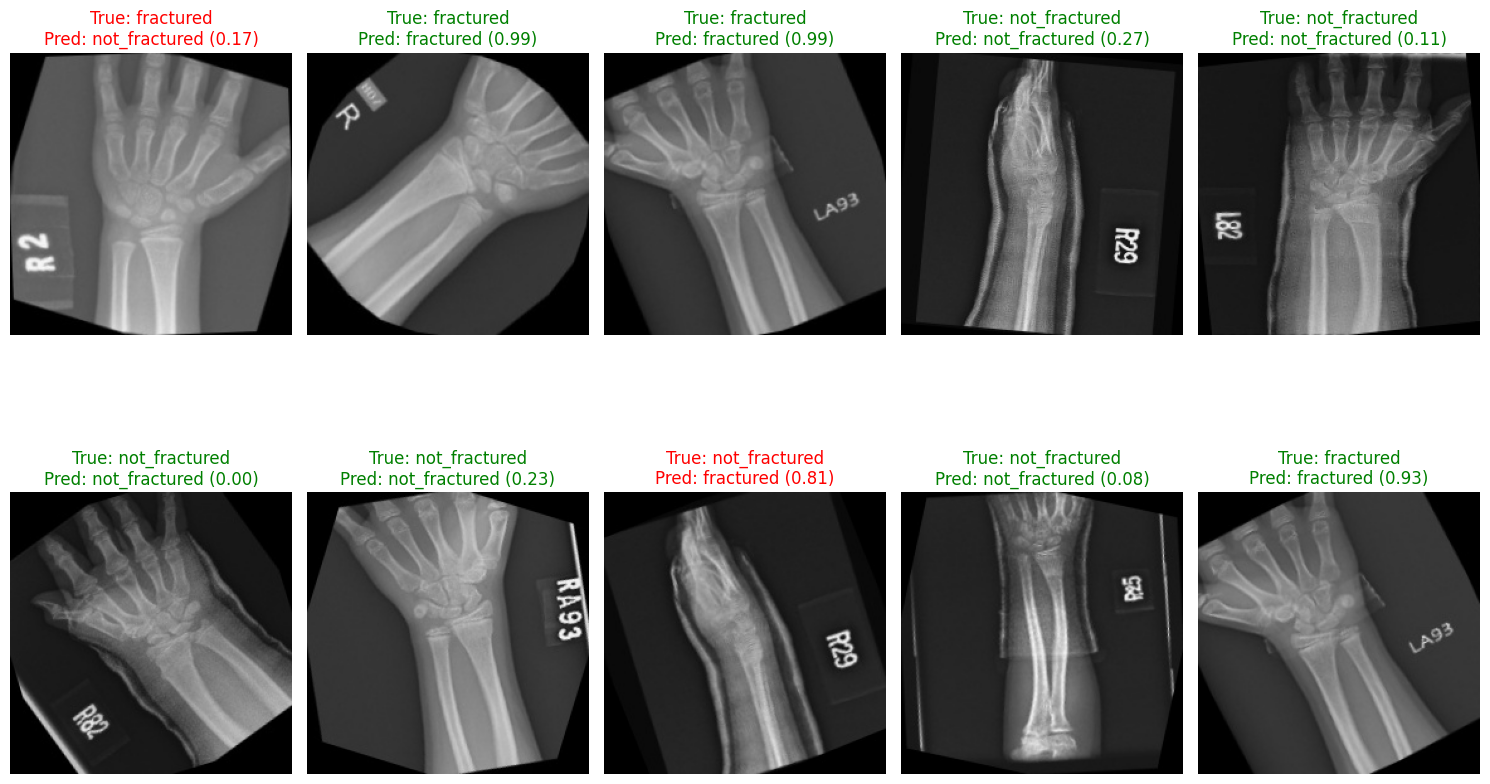

In [35]:
import random

# Map class index to label
class_labels = {0: "not_fractured", 1: "fractured"}

# Predict probabilities
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Show 10 random test images with predictions
plt.figure(figsize=(15, 10))

for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})",
              color="green" if true_label == predicted_label else "red")
    plt.axis('off')

plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

❌ Total wrong predictions: 180


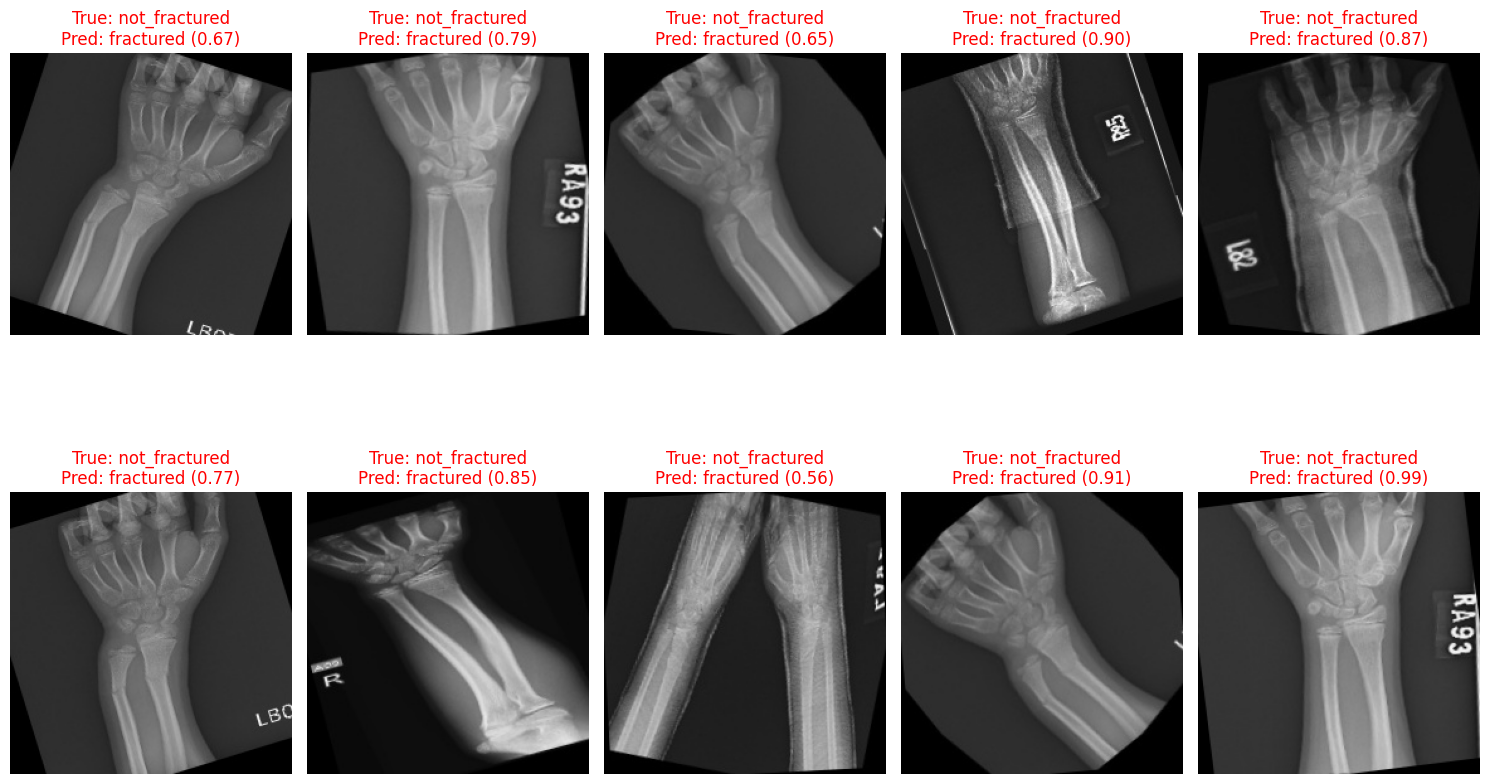

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Define label mapping
class_labels = {0: "not_fractured", 1: "fractured"}

# Find indices of incorrect predictions
wrong_indices = np.where(y_preds != y_test)[0]

print(f"\n❌ Total wrong predictions: {len(wrong_indices)}")

# Display some wrongly predicted images
plt.figure(figsize=(15, 10))

for i, idx in enumerate(wrong_indices[:10]):  # Show first 10 wrong predictions
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


## **END OF MoblieNetV2**
